In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
#importing the dataset
df = pd.read_csv(r'C:\Users\Anshu\Downloads\mw_pw_profiles.csv')
df.head()

C:\Users\Anshu\AppData\Local\Temp\ipykernel_23304\2467855252.py:2: DtypeWarning: Columns (32,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\Anshu\Downloads\mw_pw_profiles.csv')


,player_id,match_id,gender,balls_per_over,start_date,series_name,match_type,name_x,runs_scored,player_out,...,key_pulse,key_pulse_2,full_name,batting_style,bowling_style,playing_role,teams,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,00015688,1158348,female,6,2018-08-21,Botswana Cricket Association Women's T20I Series,T20,M King,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,[],5,8,17
1,00015688,1182644,female,6,2019-05-05,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,[],3,0,7
2,00015688,1275107,female,6,2021-09-09,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,[],1,0,5
3,00015688,1275113,female,6,2021-09-15,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,0,4
4,00015688,1275125,female,6,2021-09-14,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,[],-5,0,-1


In [3]:
#dropping the columns with more than 50% missing values
# dropping the columns with more than 50% nan values
threshold = len(df) * 0.5  # 50% threshold
df.dropna(axis=1, thresh=threshold,inplace = True)
df.drop(['key_cricinfo' , 'key_cricketarchive' , 'key_pulse'] , axis = 1 , inplace = True)
df.head()

,player_id,match_id,gender,balls_per_over,start_date,series_name,match_type,name_x,runs_scored,player_out,...,maidens,dot_balls_as_bowler,player_team,opposition_team,name_y,unique_name,teams,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,00015688,1158348,female,6,2018-08-21,Botswana Cricket Association Women's T20I Series,T20,M King,10,1,...,0,0,Sierra Leone,Namibia,M King,M King,[],5,8,17
1,00015688,1182644,female,6,2019-05-05,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,8,1,...,0,0,Sierra Leone,Uganda,M King,M King,[],3,0,7
2,00015688,1275107,female,6,2021-09-09,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,0,...,0,0,Sierra Leone,Nigeria,M King,M King,[],1,0,5
3,00015688,1275113,female,6,2021-09-15,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,0,0,...,0,0,Sierra Leone,Cameroon,M King,M King,[],0,0,4
4,00015688,1275125,female,6,2021-09-14,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,1,...,0,0,Sierra Leone,Uganda,M King,M King,[],-5,0,-1


In [7]:
#df['balls_per_over'].unique()

In [4]:
# checking the datatypes of each columns
df.dtypes

player_id                object
match_id                 object
gender                   object
balls_per_over            int64
start_date               object
series_name              object
match_type               object
name_x                   object
runs_scored               int64
player_out                int64
balls_faced               int64
fours_scored              int64
sixes_scored              int64
catches_taken             int64
run_out_direct            int64
run_out_throw             int64
stumpings_done            int64
out_kind                 object
dot_balls_as_batsman      int64
order_seen                int64
balls_bowled              int64
runs_conceded             int64
wickets_taken             int64
bowled_done               int64
lbw_done                  int64
maidens                   int64
dot_balls_as_bowler       int64
player_team              object
opposition_team          object
name_y                   object
unique_name              object
teams   

In [5]:
# let's know how many rows have missing data
len(df.loc[df['fantasy_score_total'] == ' '])



0

from the above result it shows that fantasy score has been recorded for each player for each match

In [36]:
#first we will do analysis for the t20 format
df_t20 = df.loc[df['match_type'] == 'T20']
# Step 1: Ensure 'start_date' is datetime type
df_t20['start_date'] = pd.to_datetime(df_t20['start_date'])

# Step 2: Sort the DataFrame by player and match date (oldest match first)
df_t20 = df_t20.sort_values(by=['player_id', 'start_date'], ascending=[True, True])

C:\Users\Anshu\AppData\Local\Temp\ipykernel_23304\1214329883.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t20['start_date'] = pd.to_datetime(df_t20['start_date'])


In [37]:
# Adding new columns in df
#using a new function to calculate the strike_rate1,strike_rate5 and strike_rate10 and economy_rate1,economy_rate5 and economy_rate10 and adding them to df_t20
# where 1, 5, and 10 represent the last 1, 5, and 10 matches respectively using rolling window calculations and shifting the values
# Step 3: Function to calculate rolling rates
def calculate_Rates(df, last_n_matches):
    df[f'strike_rate{last_n_matches}'] = (
        df['runs_scored'].shift(1).rolling(window=last_n_matches, min_periods=last_n_matches).sum() /
        df['balls_faced'].shift(1).rolling(window=last_n_matches, min_periods=last_n_matches).sum()
    ) * 100

    df[f'economy_rate{last_n_matches}'] = (
        df['runs_conceded'].shift(1).rolling(window=last_n_matches, min_periods=last_n_matches).sum() /
        df['balls_bowled'].shift(1).rolling(window=last_n_matches, min_periods=last_n_matches).sum()
    ) * 6

    return df

# Step 4: Apply rolling function group-wise per player
for n in [1, 5, 10]:
    df_t20 = df_t20.groupby('player_id', group_keys=False).apply(lambda x: calculate_Rates(x, n))
# Step 5: Fill NaN values with 0 for the newly created columns
for n in [1, 5, 10]:
    df_t20[f'strike_rate{n}'].fillna(0, inplace=True)
    df_t20[f'economy_rate{n}'].fillna(0, inplace=True)
# Displaying the updated DataFrame
df_t20.head()

C:\Users\Anshu\AppData\Local\Temp\ipykernel_23304\1255825932.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_t20 = df_t20.groupby('player_id', group_keys=False).apply(lambda x: calculate_Rates(x, n))
C:\Users\Anshu\AppData\Local\Temp\ipykernel_23304\1255825932.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_t20 = df_t20.groupby('player_id', group_keys=False).apply(lambda x: calculate_Rates(x

,player_id,match_id,gender,balls_per_over,start_date,series_name,match_type,name_x,runs_scored,player_out,...,teams,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total,strike_rate1,economy_rate1,strike_rate5,economy_rate5,strike_rate10,economy_rate10
0,00015688,1158348,female,6,2018-08-21,Botswana Cricket Association Women's T20I Series,T20,M King,10,1,...,[],5,8,17,0.000000,0.0,0.0,0.0,0.0,0.0
1,00015688,1182644,female,6,2019-05-05,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,8,1,...,[],3,0,7,33.333333,0.0,0.0,0.0,0.0,0.0
2,00015688,1275107,female,6,2021-09-09,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,0,...,[],1,0,5,44.444444,0.0,0.0,0.0,0.0,0.0
4,00015688,1275125,female,6,2021-09-14,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,1,...,[],-5,0,-1,20.000000,0.0,0.0,0.0,0.0,0.0
3,00015688,1275113,female,6,2021-09-15,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,0,0,...,[],0,0,4,6.666667,0.0,0.0,0.0,0.0,0.0


In [38]:
#removing the column match_type as it is not required now
df_t20.drop(['match_type'], axis=1, inplace=True)
# converting gender column to numerical values
df_t20['gender'] = df_t20['gender'].map({'male': 1, 'female': 0})


In [73]:
# Selecting feature columns
# feature columns will include all columns except the target column and player_id
exclude_columns = ['fantasy_score_total', 'player_id','series_name','name_x','out_kind','start_date','match_id','name_y','player_team',
                   'opposition_team','unique_name','teams','fantasy_score_batting','fantasy_score_bowling',
                   ]
feature_columns = [col for col in df_t20.columns if col not in exclude_columns]

X = df_t20[feature_columns]
y = df_t20['fantasy_score_total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
df_t20.dtypes

player_id                        object
match_id                         object
gender                            int64
balls_per_over                    int64
start_date               datetime64[ns]
series_name                      object
name_x                           object
runs_scored                       int64
player_out                        int64
balls_faced                       int64
fours_scored                      int64
sixes_scored                      int64
catches_taken                     int64
run_out_direct                    int64
run_out_throw                     int64
stumpings_done                    int64
out_kind                         object
dot_balls_as_batsman              int64
order_seen                        int64
balls_bowled                      int64
runs_conceded                     int64
wickets_taken                     int64
bowled_done                       int64
lbw_done                          int64
maidens                           int64


In [ ]:
# # importing modules for xgboost regression
# import xgboost as xgb
# # Creating DMatrix for XGBoost
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
# # Setting parameters for XGBoost
# params = {
#     'objective': 'reg:squarederror',
#     'max_depth': 5,
#     'eta': 0.1,
#     'eval_metric': 'rmse'
# }
# # Training the model
# model = xgb.train(params, dtrain, num_boost_round=100)
# # Making predictions
# y_pred_xgb = model.predict(dtest)
# # Evaluating the XGBoost model
# mse_xgb = mean_squared_error(y_test, y_pred_xgb)
# r2_xgb = r2_score(y_test, y_pred_xgb)
# print(f'XGBoost Mean Squared Error: {mse_xgb}')
# print(f'XGBoost R^2 Score: {r2_xgb}')
# # Plotting feature importance for XGBoost
# xgb.plot_importance(model, importance_type='weight')
# plt.title('Feature Importance for XGBoost')
# plt.show()

In [76]:
X.dtypes

gender                    int64
balls_per_over            int64
runs_scored               int64
player_out                int64
balls_faced               int64
fours_scored              int64
sixes_scored              int64
catches_taken             int64
run_out_direct            int64
run_out_throw             int64
stumpings_done            int64
dot_balls_as_batsman      int64
order_seen                int64
balls_bowled              int64
runs_conceded             int64
wickets_taken             int64
bowled_done               int64
lbw_done                  int64
maidens                   int64
dot_balls_as_bowler       int64
strike_rate1            float64
economy_rate1           float64
strike_rate5            float64
economy_rate5           float64
strike_rate10           float64
economy_rate10          float64
dtype: object

In [ ]:
import xgboost as xgb
import numpy as np
from xgboost.callback import EarlyStopping

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
dvalid = xgb.DMatrix(X_test, label=y_test, missing=np.nan)

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'seed': 42
}

# Train using xgb.train with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'eval')],
    callbacks=[EarlyStopping(rounds=10, save_best=True)],
    verbose_eval=True
)


[0]	train-rmse:23.81794	eval-rmse:23.96297
[1]	train-rmse:17.23078	eval-rmse:17.37438
[2]	train-rmse:12.66973	eval-rmse:12.80798
[3]	train-rmse:9.57265	eval-rmse:9.71139
[4]	train-rmse:7.45871	eval-rmse:7.60384
[5]	train-rmse:6.04760	eval-rmse:6.18766
[6]	train-rmse:5.06124	eval-rmse:5.20451
[7]	train-rmse:4.33716	eval-rmse:4.47500
[8]	train-rmse:3.78007	eval-rmse:3.91005
[9]	train-rmse:3.40765	eval-rmse:3.53458
[10]	train-rmse:3.06825	eval-rmse:3.19793
[11]	train-rmse:2.82112	eval-rmse:2.94483
[12]	train-rmse:2.61467	eval-rmse:2.73512
[13]	train-rmse:2.44441	eval-rmse:2.56744
[14]	train-rmse:2.31980	eval-rmse:2.44281
[15]	train-rmse:2.20901	eval-rmse:2.33310
[16]	train-rmse:2.06635	eval-rmse:2.19384
[17]	train-rmse:2.00074	eval-rmse:2.12860
[18]	train-rmse:1.89280	eval-rmse:2.02287
[19]	train-rmse:1.82473	eval-rmse:1.95273
[20]	train-rmse:1.77892	eval-rmse:1.90622
[21]	train-rmse:1.73684	eval-rmse:1.86392
[22]	train-rmse:1.67486	eval-rmse:1.80588
[23]	train-rmse:1.63292	eval-rmse:1.76

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Making predictions
y_pred_xgb = model.predict(dvalid)
# Evaluating the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R^2 Score: {r2_xgb}')


XGBoost Mean Squared Error: 0.49037837982177734
XGBoost R^2 Score: 0.9995628595352173


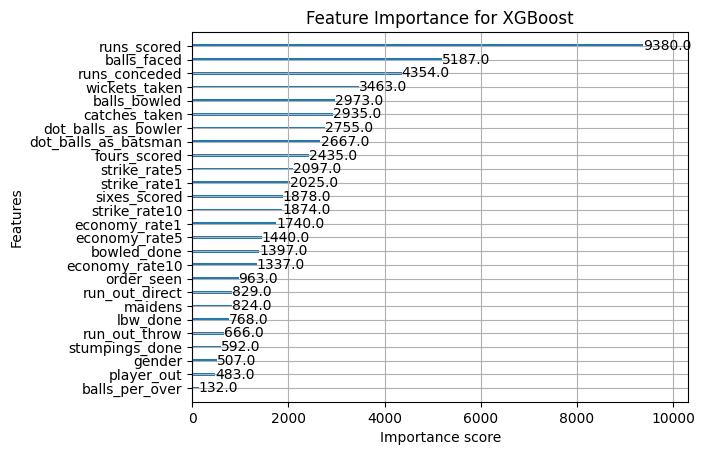

In [ ]:
# Plotting feature importance for XGBoost
xgb.plot_importance(model, importance_type='weight')
plt.title('Feature Importance for XGBoost')
plt.show()

In [80]:
# Feature Refining/Pruning
# Original features (example)
all_features = list(X_train.columns)

# Features to drop based on low importance
low_importance = [
    'order_seen', 'run_out_direct', 'maidens',
    'lbw_done', 'run_out_Throw', 'stumpings_done', 'gender'
]

# Keep only important features
pruned_features = [col for col in all_features if col not in low_importance]


In [87]:
dtrain = xgb.DMatrix(X_train[pruned_features], label=y_train)
dvalid = xgb.DMatrix(X_test[pruned_features], label=y_test)

model_pruned = xgb.train(
    params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42
    },
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=True
)


[0]	train-rmse:23.82184	eval-rmse:23.97088
[1]	train-rmse:17.24918	eval-rmse:17.38798
[2]	train-rmse:12.73728	eval-rmse:12.87852
[3]	train-rmse:9.71640	eval-rmse:9.86013
[4]	train-rmse:7.73843	eval-rmse:7.87596
[5]	train-rmse:6.46106	eval-rmse:6.60120
[6]	train-rmse:5.63517	eval-rmse:5.77938
[7]	train-rmse:5.07516	eval-rmse:5.21809
[8]	train-rmse:4.71067	eval-rmse:4.85548
[9]	train-rmse:4.46841	eval-rmse:4.61000
[10]	train-rmse:4.28679	eval-rmse:4.43292
[11]	train-rmse:4.14790	eval-rmse:4.29149
[12]	train-rmse:4.02522	eval-rmse:4.16472
[13]	train-rmse:3.94766	eval-rmse:4.08667
[14]	train-rmse:3.87725	eval-rmse:4.01620
[15]	train-rmse:3.83308	eval-rmse:3.97364
[16]	train-rmse:3.79490	eval-rmse:3.94033
[17]	train-rmse:3.76052	eval-rmse:3.90708
[18]	train-rmse:3.73288	eval-rmse:3.87938
[19]	train-rmse:3.70790	eval-rmse:3.85379
[20]	train-rmse:3.69141	eval-rmse:3.83722
[21]	train-rmse:3.67801	eval-rmse:3.82547
[22]	train-rmse:3.65715	eval-rmse:3.80568
[23]	train-rmse:3.64345	eval-rmse:3.79

In [88]:
from sklearn.metrics import mean_squared_error, r2_score

preds = model_pruned.predict(dvalid)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Pruned model MSE: {mse}")
print(f"Pruned model R²: {r2}")


Pruned model MSE: 13.23171329498291
Pruned model R²: 0.9882040023803711


MSE has significantly increased . It shows that some removed features have some non linear relation

In [89]:
# Example based on importance chart
partial_low_importance = [
    'gender', 'stumpings_done', 'run_out_Throw'
]
pruned_features_partial = [col for col in X_train.columns if col not in partial_low_importance]

dtrain = xgb.DMatrix(X_train[pruned_features_partial], label=y_train)
dvalid = xgb.DMatrix(X_test[pruned_features_partial], label=y_test)

model_pruned_partial = xgb.train(
    params={
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42
    },
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dvalid, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=True
)


from sklearn.metrics import mean_squared_error, r2_score

preds = model_pruned_partial.predict(dvalid)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Pruned model MSE: {mse}")
print(f"Pruned model R²: {r2}")


[0]	train-rmse:23.81794	eval-rmse:23.96297
[1]	train-rmse:17.23247	eval-rmse:17.37348
[2]	train-rmse:12.67743	eval-rmse:12.81420
[3]	train-rmse:9.60257	eval-rmse:9.74087
[4]	train-rmse:7.54675	eval-rmse:7.69042
[5]	train-rmse:6.16255	eval-rmse:6.30181
[6]	train-rmse:5.21168	eval-rmse:5.35322
[7]	train-rmse:4.53188	eval-rmse:4.67298
[8]	train-rmse:4.07565	eval-rmse:4.21742
[9]	train-rmse:3.72064	eval-rmse:3.86354
[10]	train-rmse:3.44182	eval-rmse:3.58388
[11]	train-rmse:3.24544	eval-rmse:3.39189
[12]	train-rmse:3.11120	eval-rmse:3.25718
[13]	train-rmse:2.95538	eval-rmse:3.10074
[14]	train-rmse:2.85650	eval-rmse:3.00059
[15]	train-rmse:2.77101	eval-rmse:2.91270
[16]	train-rmse:2.71585	eval-rmse:2.85297
[17]	train-rmse:2.62489	eval-rmse:2.76320
[18]	train-rmse:2.58533	eval-rmse:2.72447
[19]	train-rmse:2.53059	eval-rmse:2.67242
[20]	train-rmse:2.50294	eval-rmse:2.64190
[21]	train-rmse:2.47588	eval-rmse:2.61696
[22]	train-rmse:2.43790	eval-rmse:2.58021
[23]	train-rmse:2.41761	eval-rmse:2.55

'order_seen', 'run_out_direct', 'maidens',
'lbw_done', 'run_out_Throw', 'stumpings_done', 'gender'.
out of above followiing columns:-
important columns are:-
    : order_seen
    : run_out_direct  
    : maidens 
    : lbw_done 

some noticiable result
        Xtrain              Pruned Features                 Partial Pruned Features
MSE    0.49                 13.23                           4.67
R2     0.99                 0.988                           0.995
 Hence partial pruned features are giving relatively stable model

In [91]:
from sklearn.metrics import mean_absolute_error

# Predict
y_pred = model.predict(xgb.DMatrix(X_test[pruned_features_partial]))

# Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Mean of actual values
mean_actual = y_test.mean()

# MAE Percentage
mae_percent = (mae / mean_actual) * 100

print(f"MAE: {mae:.2f}")
print(f"MAE %: {mae_percent:.2f}%")



MAE: 0.85
MAE %: 2.33%


In [92]:
import numpy as np


def top11_mae_loss(y_true, y_pred, player_ids=None):
    """
    Custom loss: MAE between actual top 11 and predicted top 11 players.
    Optionally pass player_ids to match players directly.
    """
    # Convert to numpy if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Step 1: Get indices of top 11 actual and predicted players
    actual_top11_idx = np.argsort(y_true)[-11:][::-1]  # highest to lowest
    predicted_top11_idx = np.argsort(y_pred)[-11:][::-1]

    # Step 2: Match same positions (rank 1 to 11)
    actual_top11_scores = y_true[actual_top11_idx]
    predicted_top11_scores = y_pred[predicted_top11_idx]

    # Step 3: Calculate MAE between matched top 11
    mae = np.mean(np.abs(actual_top11_scores - predicted_top11_scores))

    # Optional: Show player_ids (if available)
    if player_ids is not None:
        actual_top11_players = np.array(player_ids)[actual_top11_idx]
        predicted_top11_players = np.array(player_ids)[predicted_top11_idx]
        print("Top 11 Actual Player IDs:", actual_top11_players)
        print("Top 11 Predicted Player IDs:", predicted_top11_players)

    return mae


In [94]:

# Custom loss
custom_top11_loss = top11_mae_loss(y_test, y_pred, player_ids=X_test.index)
print(f"Top-11 MAE Loss: {custom_top11_loss:.2f}")


Top 11 Actual Player IDs: [348583 362391 161737 359829 302913 378112 204617 253055 109122   2890
 214631]
Top 11 Predicted Player IDs: [161737 378112 362391 359829 204617 214631 348583 253055 177685 302913
 109122]
Top-11 MAE Loss: 12.43


In [98]:
import shap
import xgboost as xgb

# Prepare your DMatrix again (if needed)
dtrain = xgb.DMatrix(X_train[pruned_features_partial], label=y_train)
dtest = xgb.DMatrix(X_test[pruned_features_partial], label=y_test)
num_boost_round = 300
model = xgb.train(params, dtrain, num_boost_round)
# SHAP explainer for XGBoost
explainer = shap.TreeExplainer(model)  # ✅ works if model is a Booster



In [99]:
#calculating shap values
shap_values = explainer.shap_values(X_test[pruned_features_partial])


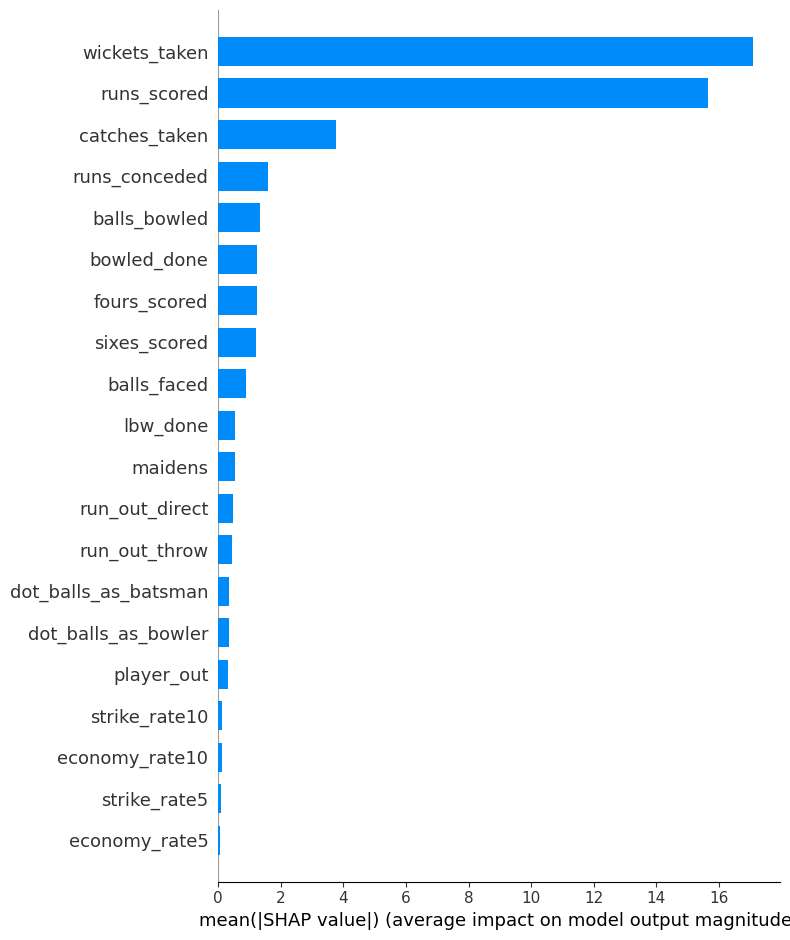

In [100]:
#plotting the shap values
shap.summary_plot(shap_values, X_test[pruned_features_partial], plot_type="bar")
